In [ ]:
!pip install -q boto3
!pip install -q xgboost==0.90
!pip install -q scikit-learn==0.20.3
!pip install -q nltk==3.4.5

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [2]:
!aws s3 cp 's3://{bucket}/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./data/

download: s3://sagemaker-us-east-1-835319576252/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [3]:
import csv

df = pd.read_csv('./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz', 
                 delimiter='\t', 
                 quoting=csv.QUOTE_NONE,
                 compression='gzip')
df.shape

(102084, 15)

In [4]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


# Clean commas from raw text
_Note:  This is not needed as the data does not currently contain commas._

In [5]:
df_scrubbed_raw = df

df_scrubbed_raw['marketplace'] = df_scrubbed_raw['marketplace'].replace(',', ' ')
df_scrubbed_raw['review_id'] = df_scrubbed_raw['review_id'].replace(',', ' ')
df_scrubbed_raw['product_id'] = df_scrubbed_raw['product_id'].replace(',', ' ')
df_scrubbed_raw['product_title'] = df_scrubbed_raw['product_title'].replace(',', ' ')
df_scrubbed_raw['product_category'] = df_scrubbed_raw['product_category'].replace(',', ' ')
df_scrubbed_raw['review_headline'] = df_scrubbed_raw['review_headline'].replace(',', ' ')
df_scrubbed_raw['review_body'] = df_scrubbed_raw['review_body'].replace(',', ' ')
df_scrubbed_raw['review_date'] = df_scrubbed_raw['review_date'].replace(',', ' ')

df_scrubbed_raw.shape

(102084, 15)

In [6]:
df_scrubbed_raw.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


# Drop NaNs

In [7]:
df_scrubbed_raw.isna().values.any()

False

In [8]:
df_scrubbed_raw = df_scrubbed_raw.dropna()
df_scrubbed_raw = df_scrubbed_raw.reset_index(drop=True)
df_scrubbed_raw.shape

(102084, 15)

In [9]:
df_scrubbed_raw.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


### Enrich the data with `is_positive_sentiment` label
* True:  `star_rating >= 4`
* False:  `star_rating < 4`

In [10]:
df_is_positive_sentiment = (df_scrubbed_raw['star_rating'] >= 4).astype(int)
df_scrubbed_raw.insert(0, 'is_positive_sentiment', df_is_positive_sentiment)
df_scrubbed_raw.shape

(102084, 16)

In [11]:
df_scrubbed_raw.head(5)

,is_positive_sentiment,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,1,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,0,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,0,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,1,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,1,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


# Split the data into `train` and `test` datasets

In [14]:
from sklearn.model_selection import train_test_split

df_unbalanced_raw = df_scrubbed_raw

print('df_unbalanced_raw.shape={}'.format(df_unbalanced_raw.shape))

# Split all data into 90% train and 10% test
df_unbalanced_raw_train, df_unbalanced_raw_test = train_test_split(df_unbalanced_raw, test_size=0.1, stratify=df_scrubbed_raw['is_positive_sentiment'])

df_unbalanced_raw_train = df_unbalanced_raw_train.reset_index(drop=True)
df_unbalanced_raw_test = df_unbalanced_raw_test.reset_index(drop=True)

print('df_unbalanced_raw_train.shape={}'.format(df_unbalanced_raw_train.shape))
print('df_unbalanced_raw_test.shape={}'.format(df_unbalanced_raw_test.shape))

df_unbalanced_raw.shape=(102084, 16)
df_unbalanced_raw_train.shape=(91875, 16)
df_unbalanced_raw_test.shape=(10209, 16)


## Write the data files locally

In [16]:
prefix_unbalanced_raw_train = 'feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-train-csv'
prefix_unbalanced_raw_test = 'feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-test-csv'

unbalanced_raw_with_header_train_path = './{}/data.csv'.format(prefix_unbalanced_raw_train)
unbalanced_raw_with_header_test_path = './{}/data.csv'.format(prefix_unbalanced_raw_test)

import os
os.makedirs(prefix_unbalanced_raw_train, exist_ok=True)
os.makedirs(prefix_unbalanced_raw_test, exist_ok=True)

df_unbalanced_raw_train[['is_positive_sentiment', 'review_body']].to_csv(unbalanced_raw_with_header_train_path, index=False, header=True)
df_unbalanced_raw_test[['is_positive_sentiment', 'review_body']].to_csv(unbalanced_raw_with_header_test_path, index=False, header=True)


In [17]:
unbalanced_raw_with_header_train_s3_uri = sess.upload_data(path=unbalanced_raw_with_header_train_path, key_prefix=prefix_unbalanced_raw_train)
unbalanced_raw_with_header_test_s3_uri = sess.upload_data(path=unbalanced_raw_with_header_test_path, key_prefix=prefix_unbalanced_raw_test)

print(unbalanced_raw_with_header_train_s3_uri)
print(unbalanced_raw_with_header_test_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-train-csv/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews-autopilot/raw-labeled-split-unbalanced-header-test-csv/data.csv


In [18]:
!aws s3 ls $unbalanced_raw_with_header_train_s3_uri
!aws s3 ls $unbalanced_raw_with_header_test_s3_uri

2020-03-13 19:10:40   34795839 data.csv
2020-03-13 19:10:44    3809746 data.csv


# View the Class Imbalance (Train)

### Note:  You may need to run this next cell twice


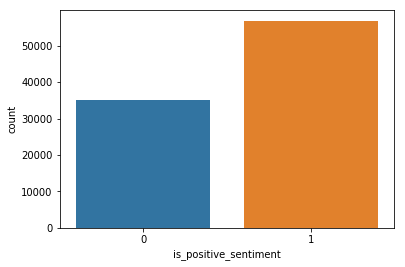

In [21]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_unbalanced_raw_train)


In [22]:
is_positive_sentiment_count_unbalanced_raw_train = len(df_unbalanced_raw_train.query('is_positive_sentiment == 1'))
is_negative_sentiment_count_unbalanced_raw_train = len(df_unbalanced_raw_train.query('is_positive_sentiment == 0'))

print('Majority (positive) count: {}'.format(is_positive_sentiment_count_unbalanced_raw_train))
print('Minority (negative) count: {}'.format(is_negative_sentiment_count_unbalanced_raw_train))
print('Ratio of Majority to Minority: {}'.format(is_positive_sentiment_count_unbalanced_raw_train / is_negative_sentiment_count_unbalanced_raw_train))

Majority (positive) count: 56792
Minority (negative) count: 35083
Ratio of Majority to Minority: 1.618789727218311


# Balance the Classes (Train-Split Only)

In [27]:
from sklearn.utils import resample

is_negative_sentiment_unbalanced_raw_train_df = df_unbalanced_raw_train.query('is_positive_sentiment == 0')
is_positive_sentiment_unbalanced_raw_train_df = df_unbalanced_raw_train.query('is_positive_sentiment == 1')

# TODO:  Check which sentiment has the least number of samples
#        We know we have more positive than negative sentiment samples in our case.

is_positive_downsampled_raw_train_df = resample(is_positive_sentiment_unbalanced_raw_train_df,
                                                replace = False,
                                                n_samples = len(is_negative_sentiment_unbalanced_raw_train_df))

df_balanced_train_raw = pd.concat([is_negative_sentiment_unbalanced_raw_train_df, is_positive_downsampled_raw_train_df])
df_balanced_train_raw = df_balanced_train_raw.reset_index(drop=True)

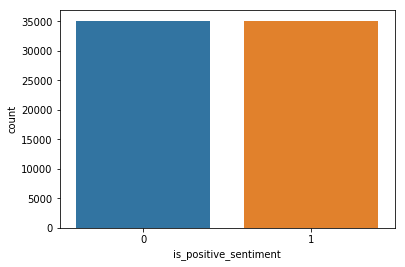

In [28]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_balanced_train_raw)


## Write the data files locally (Balanced, Train)


In [33]:
prefix_balanced_raw_train = 'feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-train-csv'

balanced_raw_with_header_train_path = './{}/data.csv'.format(prefix_balanced_raw_train)

import os
os.makedirs(prefix_balanced_raw_train, exist_ok=True)

df_balanced_train_raw[['is_positive_sentiment', 'review_body']].to_csv(balanced_raw_with_header_train_path, index=False, header=True)


## Upload Only S3 (Balanced, Train)
We will use the test set later to verify.

In [34]:
balanced_raw_with_header_train_s3_uri = sess.upload_data(path=balanced_raw_with_header_train_path, key_prefix=prefix_balanced_raw_train)

print(balanced_raw_with_header_train_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-train-csv/data.csv


In [35]:
!aws s3 ls $balanced_raw_with_header_train_s3_uri


2020-03-13 19:13:41   28515006 data.csv


# Balance the Classes (Test-Split Only)

In [36]:
from sklearn.utils import resample

is_negative_sentiment_unbalanced_raw_test_df = df_unbalanced_raw_test.query('is_positive_sentiment == 0')
is_positive_sentiment_unbalanced_raw_test_df = df_unbalanced_raw_test.query('is_positive_sentiment == 1')

# TODO:  Check which sentiment has the least number of samples
#        We know we have more positive than negative sentiment samples in our case.

is_positive_downsampled_raw_test_df = resample(is_positive_sentiment_unbalanced_raw_test_df,
                                                replace = False,
                                                n_samples = len(is_negative_sentiment_unbalanced_raw_test_df))

df_balanced_test_raw = pd.concat([is_negative_sentiment_unbalanced_raw_test_df, is_positive_downsampled_raw_test_df])
df_balanced_test_raw = df_balanced_test_raw.reset_index(drop=True)

In [37]:
df_balanced_test_raw.head(5)

,is_positive_sentiment,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,0,US,36243605,R3PPS11U7987KT,B00PG8FOSY,801860929,Block Financial H&R Block Tax Software 14 Delu...,Digital_Software,1,1,3,N,Y,Software Distribution Fail...,Perhaps it would be good if it would download!...,2015-02-07
1,0,US,39118414,R3HET6DM7DFI5U,B00E7X9RUK,109813655,Quicken Deluxe 20,Digital_Software,3,0,0,N,Y,Generally Meh,"Okay, so I've been using Quicken since it was ...",2014-01-31
2,0,US,4889139,RXQHIVPATBJ62,B00NG7JVSQ,811978073,TurboTax Deluxe Fed + Efile + State,Digital_Software,1,2,2,N,N,No longer a big fan,Have used TurboTax for many years without inci...,2015-02-19
3,0,US,29355373,R16OR66WKOFLLB,B0064PF4ZQ,893514095,Office Mac 2011 Home and Business 2011 - 1 Mac...,Digital_Software,3,1,1,N,Y,It's Office,I was required to have Microsoft Office for my...,2013-08-26
4,0,US,52803275,R14CC6L5DHUN6F,B00E7X9RUK,109813655,Quicken Deluxe 20,Digital_Software,1,1,2,N,N,"Crashes Constantly, Do Not Buy",Google &#34;Quicken 2014 crashes&#34; and you'...,2013-11-26


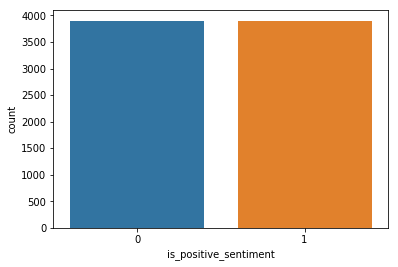

In [38]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_balanced_test_raw)


## Write the data files locally (Balanced, Test)


In [42]:
prefix_balanced_test_raw = 'feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-test-csv'
balanced_raw_with_header_test_path = './{}/data.csv'.format(prefix_balanced_test_raw)

import os
os.makedirs(prefix_balanced_test_raw, exist_ok=True)
df_balanced_test_raw[['is_positive_sentiment', 'review_body']].to_csv(balanced_raw_with_header_test_path, index=False, header=True)


## Upload Only S3 (Balanced, Test)
We will use the test set later to verify.

In [43]:
balanced_raw_with_header_test_s3_uri = sess.upload_data(path=balanced_raw_with_header_test_path, key_prefix=prefix_balanced_raw_test)

print(balanced_raw_with_header_test_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews-autopilot/raw-labeled-split-balanced-header-test-csv/data.csv


In [44]:
!aws s3 ls $balanced_raw_with_header_test_s3_uri


2020-03-13 19:14:20    3115766 data.csv
